In [1]:
import os
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt

### Initialise the environment

In [2]:
p1 = 0.7 # reward proba for arm 1
p2 = 0.5 # reward proba for arm 2

arms = [p1, p2]

### Initialise the agent

In [3]:
def policy(q_values, temp=None):

    if temp:
        t = temp
    else:
        t = 1
    return np.exp(q_values*t)/np.sum(np.exp(q_values*t))

def belief_update(M_curr, arm, rew):

    M_next = M_curr.copy()
    if rew == 1:
        M_next[arm, 0] += 1
    else:
        M_next[arm, 1] += 1
    return M_next

In [22]:
# initial belief state
M = np.array([
    [1, 1],
    [1, 1]
])

# initial Q values
Q = np.array([0.1, 0.1])

# parameters
alpha = 0.1
gamma = 0.9
temp  = 6

### Run the model-free agent

In [23]:
np.random.seed(1234)

num_episodes = 10
for ep in range(num_episodes):
    probas = policy(Q, temp=temp)
    a      = np.random.choice([0, 1], p=probas)
    r      = np.random.choice([0, 1], p=(1-arms[a], arms[a]))
    Q[a]  += alpha*(r - Q[a])
    M      = belief_update(M, a, r)

### Plot the resulting belief

Text(0.5, 1.0, 'MF Q values')

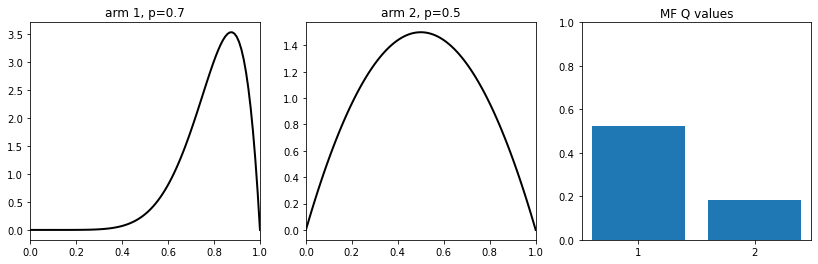

In [25]:
plt.figure(figsize=(14, 4))

x = np.linspace(0, 1, 100)
plt.subplot(1, 3, 1)
a, b = M[0, 0], M[0, 1]
rv = beta(a, b)
plt.plot(x, rv.pdf(x), 'k-', lw=2)
plt.xlim(0,1)
plt.title('arm 1, p=%.1f'%arms[0])
plt.subplot(1, 3, 2)
a, b = M[1, 0], M[1, 1]
rv = beta(a, b)
plt.plot(x, rv.pdf(x), 'k-', lw=2)
plt.xlim(0,1)
plt.title('arm 2, p=%.1f'%arms[1])
plt.subplot(1, 3, 3)
plt.bar([1, 2], Q)
plt.xticks([1, 2], [1, 2])
plt.ylim(0,1)
plt.title('MF Q values')

### Belief MDP value iteration

In [ ]:
def get_belief_tree(h, b):

    # initialise the hyperstate tree
    tree = {hi:{} for hi in range(h)}
    
    tree[0][(0, 0)] = b
    tree[0][(1, 0)] = b

    for hi in range(1, h):
        c  = 0
        for k, v in tree[hi-1].items():
            
            prev_a = k[0]
            prev_c = k[-1]
            
            for r in [0, 1]:
                b1 = belief_update(v, prev_a, r)
                
                for a1 in range(2):
                    
                    tree[hi][(a1, prev_c, c)] = b1
                    c += 1
    return tree

def belief_vi(current_s, current_a, h, current_b):
    
    belief_tree    = get_belief_tree(current_s, current_a, h, current_b)
    
    # Compute the values of all information states 
    # reached at horizon h
    
    hi = (h-1)
    
    this_tree      = belief_tree[hi]
    q_values_tree  = {hi:{} for hi in range(h)}
    entropies_tree = {hi:{} for hi in range(h)}
    probas_tree    = {hi:{} for hi in range(h)}
    
    for k, v in this_tree.items():
        
        M = v.copy()
        b = M/np.sum(M, axis=1)[:, None]
        
        s = k[0]
        a = k[1]
        
        c = k[-1]
        
        q_max = np.nanmax(Q_MF, axis=1)
        
        if s == r_state:
            q_val = 0
        else:
            r     = world.ravel()
            q_val = np.dot(b[s*num_actions+a, :], r + gamma*q_max)
        
        ent = np.zeros(M.shape[0])
        for i in range(len(ent)):
            ent[i] = dirichlet.entropy(M[i, :])
        
        q_values_tree[hi][k]  = q_val
        entropies_tree[hi][k] = ent
        probas_tree[hi][k]    = b
                
    for hi in reversed(range(0, h-1)):
        
        this_tree          = belief_tree[hi]
        new_entropies_tree = {}
        new_q_values_tree  = {}
        new_probas_tree    = {}
        
        for k, v in this_tree.items():
            
            M  = v.copy()
            b  = M/np.sum(M, axis=1)[:, None]
            
            s  = k[0]
            a  = k[1]
            
            c  = k[-1]
            
            tmp      = {}
            tmp_ent  = {}
            tmp_prob = {}
            
            for kv, vv in q_values_tree[hi+1].items():
                if kv[-2] == c:
                    tmp[kv]      = vv
                    tmp_ent[kv]  = entropies_tree[hi+1][kv]
                    tmp_prob[kv] = probas_tree[hi+1][kv]
                    
            if tmp == {}:

                q_max = np.nanmax(Q_MF, axis=1)
                ent   = np.zeros(M.shape[0])
                prob  = b
                
                for i in range(len(ent)):
                    ent[i] = dirichlet.entropy(M[i, :])

                # Q_MB_tmp = value_iteration(Q_MF, M, world, r_state, gamma)
                # q_val    = Q_MB_tmp[s, a]
                
                if s == r_state:
                    q_val = 0
                else:
                    r     = world.ravel()
                    q_val = np.dot(b[s*num_actions+a, :], r + gamma*q_max)

            else:
                q_val = 0
                ent   = np.zeros(M.shape[0])
                prob  = np.zeros((num_states*num_actions, num_states))
                keys  = list(tmp.keys())
                
                for key_idx in range(0, len(keys), num_actions):
                    qs = []
                    es = []
                    ps = []
                    s1 = int(keys[key_idx][0])
                    
                    for t in range(num_actions):
                        qs += [tmp[keys[key_idx+t]]]
                        es += [tmp_ent[keys[key_idx+t]]]
                        ps += [tmp_prob[keys[key_idx+t]]]
                    
                    idx    = np.argmax(qs)
                    q_val += b[s*num_actions+a, s1]*(world.ravel()[s1] + gamma*qs[idx])
                    ent   += b[s*num_actions+a, s1]*es[idx]
                    prob  += b[s*num_actions+a, s1]*ps[idx]
                    
            new_q_values_tree[k]  = q_val
            new_entropies_tree[k] = ent
            new_probas_tree[k]    = prob
            
        q_values_tree[hi]  = new_q_values_tree
        entropies_tree[hi] = new_entropies_tree
        probas_tree[hi]    = new_probas_tree
    
    print('State %u action %u done'%(current_s, current_a))
    return belief_tree, q_values_tree, probas_tree, entropies_tree